# Image Features
We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

In [1]:
import random
import numpy as np
from dl4cv.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk. However, we don't apply our previous preprocessing steps, as we want to extract custom features later on.

Train data shape:  (48000, 32, 32, 3)
Train labels shape:  (48000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


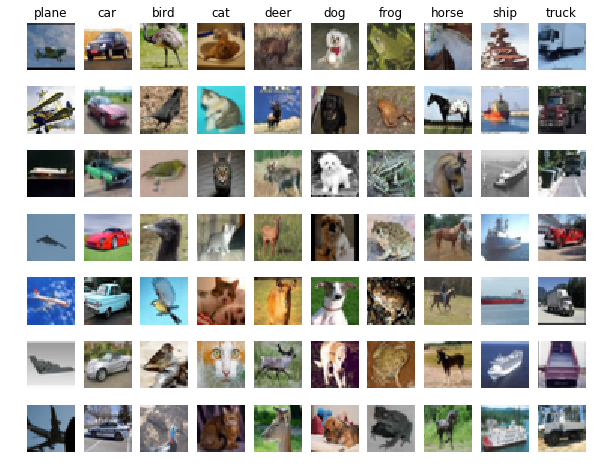

In [2]:
from dl4cv.data_utils import load_CIFAR10
from dl4cv.vis_utils import visualize_cifar10

def get_CIFAR10_data(num_training=48000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for feature extraction and training.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/'
    X, y = load_CIFAR10(cifar10_dir)
    

    # Our training set will be the first num_train points from the original
    # training set.
    mask = range(num_training)
    X_train = X[mask]
    y_train = y[mask]
    
    # Our validation set will be num_validation points from the original
    # training set.
    mask = range(num_training, num_training + num_validation)
    X_val = X[mask]
    y_val = y[mask]
    
    # We use a small subset of the training set as our test set.
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    X_test = X[mask]
    y_test = y[mask]

    return X, y, X_train, y_train, X_val, y_val, X_test, y_test

# Invoke the above function to get our data.
X_raw, y_raw, X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# visualize raw data
visualize_cifar10(X_raw, y_raw)

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from dl4cv.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 48000 images
Done extracting features for 2000 / 48000 images
Done extracting features for 3000 / 48000 images
Done extracting features for 4000 / 48000 images
Done extracting features for 5000 / 48000 images
Done extracting features for 6000 / 48000 images
Done extracting features for 7000 / 48000 images
Done extracting features for 8000 / 48000 images
Done extracting features for 9000 / 48000 images
Done extracting features for 10000 / 48000 images
Done extracting features for 11000 / 48000 images
Done extracting features for 12000 / 48000 images
Done extracting features for 13000 / 48000 images
Done extracting features for 14000 / 48000 images
Done extracting features for 15000 / 48000 images
Done extracting features for 16000 / 48000 images
Done extracting features for 17000 / 48000 images
Done extracting features for 18000 / 48000 images
Done extracting features for 19000 / 48000 images
Done extracting features for 20000 / 48000 images
Done extr

## Train a Softmax classifier on features
Using the multiclass Softmax code developed earlier in the assignment, train a Softmax classifier on top of the features extracted above; this should achieve better results than training the classifier directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from dl4cv.classifiers.linear_classifier import Softmax

#learning_rates = [1e-9, 1e-8, 1e-7]
#regularization_strengths = [1e5, 1e6, 1e7]
learning_rates = [1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 1e-5]
regularization_strengths = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]

results = {}
best_val = -1
best_softmax = None


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the Softmax; save#
# the best trained classifer in best_softmax. You might also want to play      #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train_feats, y_train, learning_rate=lr, reg=rs,
                          num_iters=1500, verbose=True)
        y_train_pred = softmax.predict(X_train_feats)
        y_val_pred = softmax.predict(X_val_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax
            
        results[(lr,rs)] = train_accuracy, val_accuracy

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
          lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during validation: %f' % best_val)

iteration 0 / 1500: loss 2.302910
iteration 100 / 1500: loss 2.302455
iteration 200 / 1500: loss 2.302803
iteration 300 / 1500: loss 2.302234
iteration 400 / 1500: loss 2.303740
iteration 500 / 1500: loss 2.303924
iteration 600 / 1500: loss 2.303710
iteration 700 / 1500: loss 2.302846
iteration 800 / 1500: loss 2.302669
iteration 900 / 1500: loss 2.302851
iteration 1000 / 1500: loss 2.304544
iteration 1100 / 1500: loss 2.302850
iteration 1200 / 1500: loss 2.303320
iteration 1300 / 1500: loss 2.303435
iteration 1400 / 1500: loss 2.303366
iteration 0 / 1500: loss 2.304506
iteration 100 / 1500: loss 2.304273
iteration 200 / 1500: loss 2.304634
iteration 300 / 1500: loss 2.302853
iteration 400 / 1500: loss 2.303527
iteration 500 / 1500: loss 2.301869
iteration 600 / 1500: loss 2.302895
iteration 700 / 1500: loss 2.302957
iteration 800 / 1500: loss 2.302684
iteration 900 / 1500: loss 2.302755
iteration 1000 / 1500: loss 2.301684
iteration 1100 / 1500: loss 2.304150
iteration 1200 / 1500: lo

iteration 300 / 1500: loss 2.302779
iteration 400 / 1500: loss 2.302529
iteration 500 / 1500: loss 2.304289
iteration 600 / 1500: loss 2.303038
iteration 700 / 1500: loss 2.304307
iteration 800 / 1500: loss 2.305212
iteration 900 / 1500: loss 2.303751
iteration 1000 / 1500: loss 2.303728
iteration 1100 / 1500: loss 2.302379
iteration 1200 / 1500: loss 2.301823
iteration 1300 / 1500: loss 2.302752
iteration 1400 / 1500: loss 2.302223
iteration 0 / 1500: loss 2.312216
iteration 100 / 1500: loss 2.311163
iteration 200 / 1500: loss 2.311365
iteration 300 / 1500: loss 2.311728
iteration 400 / 1500: loss 2.311429
iteration 500 / 1500: loss 2.312192
iteration 600 / 1500: loss 2.311506
iteration 700 / 1500: loss 2.311403
iteration 800 / 1500: loss 2.311411
iteration 900 / 1500: loss 2.310242
iteration 1000 / 1500: loss 2.310537
iteration 1100 / 1500: loss 2.310339
iteration 1200 / 1500: loss 2.310008
iteration 1300 / 1500: loss 2.311665
iteration 1400 / 1500: loss 2.311615
iteration 0 / 1500: 

iteration 800 / 1500: loss 2.302545
iteration 900 / 1500: loss 2.302545
iteration 1000 / 1500: loss 2.302548
iteration 1100 / 1500: loss 2.302560
iteration 1200 / 1500: loss 2.302557
iteration 1300 / 1500: loss 2.302545
iteration 1400 / 1500: loss 2.302550
iteration 0 / 1500: loss 80.228034
iteration 100 / 1500: loss 2.302582
iteration 200 / 1500: loss 2.302582
iteration 300 / 1500: loss 2.302582
iteration 400 / 1500: loss 2.302582
iteration 500 / 1500: loss 2.302581
iteration 600 / 1500: loss 2.302581
iteration 700 / 1500: loss 2.302581
iteration 800 / 1500: loss 2.302580
iteration 900 / 1500: loss 2.302582
iteration 1000 / 1500: loss 2.302581
iteration 1100 / 1500: loss 2.302582
iteration 1200 / 1500: loss 2.302582
iteration 1300 / 1500: loss 2.302582
iteration 1400 / 1500: loss 2.302582
iteration 0 / 1500: loss 809.913103
iteration 100 / 1500: loss 2.302585
iteration 200 / 1500: loss 2.302585
iteration 300 / 1500: loss 2.302585
iteration 400 / 1500: loss 2.302585
iteration 500 / 150

/media/virendra/data/study/3sem/DeepLearning/Tutorial/exercise1/dl4cv/exercise_1/dl4cv/classifiers/softmax.py:98: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(prob_of_right_class))
/media/virendra/data/study/3sem/DeepLearning/Tutorial/exercise1/dl4cv/exercise_1/dl4cv/classifiers/softmax.py:106: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(W * W)
/media/virendra/data/study/3sem/DeepLearning/Tutorial/exercise1/dl4cv/exercise_1/dl4cv/classifiers/softmax.py:106: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * reg * np.sum(W * W)


iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan


/media/virendra/data/study/3sem/DeepLearning/Tutorial/exercise1/dl4cv/exercise_1/dl4cv/classifiers/softmax.py:108: RuntimeWarning: overflow encountered in multiply
  dW += reg*W


iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 2.303408
iteration 100 / 1500: loss 2.301386
iteration 200 / 1500: loss 2.300827
iteration 300 / 1500: loss 2.299105
iteration 400 / 1500: loss 2.300373
iteration 500 / 1500: loss 2.299759
iteration 600 / 1500: loss 2.298874
iteration 700 / 1500: loss 2.298224
iteration 800 / 1500: loss 2.296851
iteration 900 / 1500: loss 2.295313
iteration 1000 / 1500: loss 2.297188
iteration 1100 / 1500: loss 2.295763
iteration 1200 / 1500: loss 2.295375
iteration 1300 / 1500: loss 2.294655
iteration 1400 / 1500: loss 2.294641
iteration 0 / 1500: loss 2.302455
iteration 100 / 1500: loss 2.302255
iteration 200 / 1500: loss 2.301781
iteration 300 / 1500: loss 2.300030
iteration 400 / 1500: loss 2.300776
iteration 500 / 1500: loss 2.297329
iteration 600 / 1500:

iteration 0 / 1500: loss 2.303681
iteration 100 / 1500: loss 2.301715
iteration 200 / 1500: loss 2.302334
iteration 300 / 1500: loss 2.301091
iteration 400 / 1500: loss 2.299107
iteration 500 / 1500: loss 2.299358
iteration 600 / 1500: loss 2.299349
iteration 700 / 1500: loss 2.296969
iteration 800 / 1500: loss 2.298806
iteration 900 / 1500: loss 2.296436
iteration 1000 / 1500: loss 2.296660
iteration 1100 / 1500: loss 2.294333
iteration 1200 / 1500: loss 2.293982
iteration 1300 / 1500: loss 2.293747
iteration 1400 / 1500: loss 2.291127
iteration 0 / 1500: loss 2.310261
iteration 100 / 1500: loss 2.308705
iteration 200 / 1500: loss 2.308411
iteration 300 / 1500: loss 2.308478
iteration 400 / 1500: loss 2.307682
iteration 500 / 1500: loss 2.307095
iteration 600 / 1500: loss 2.304992
iteration 700 / 1500: loss 2.305292
iteration 800 / 1500: loss 2.305894
iteration 900 / 1500: loss 2.302160
iteration 1000 / 1500: loss 2.302835
iteration 1100 / 1500: loss 2.300631
iteration 1200 / 1500: lo

In [5]:
# Evaluate your trained classifier on the test set
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.402


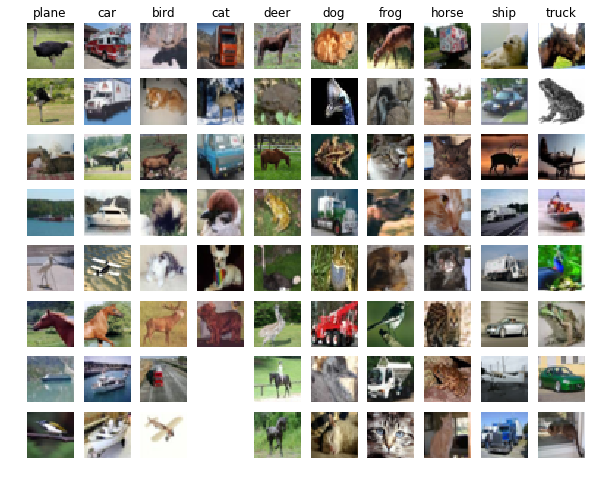

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    if len(idxs) > 0:
        idxs = np.random.choice(idxs, min(examples_per_class, len(idxs)), replace=False)
    else:
        idxs = []
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Describe the misclassification results that you see. Do they make sense?</p>
</div>

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set.

Note that in the neural net class we have used explicit biases. In the preprocessing of this exercise we have also added a bias dimension to the input, such that we don't have to consider an explicit bias in the linear classifier above. The neural net therefore has an additional parameter in the first layer (the additional bias term), which after all does not matter, as both bias terms can be learned. So just don't get confused by this.

In [15]:
from dl4cv.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
#net = TwoLayerNet(input_dim, hidden_dim, num_classes)
# Train the network
#stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
#num_iters=5000, batch_size=256,
#learning_rate=0.9, learning_rate_decay=0.95,
#reg=1e-3, verbose=True)

# Predict on the validation set
#val_acc = (net.predict(X_val_feats) == y_val).mean()
#print('Validation accuracy: ', val_acc)

#best_net = net

best_val = -1
best_stats = None
#learning_rates = [1e-2, 1e-3]
#regularization_strengths = [0.4, 0.5, 0.6]

#learning_rates = [1e-3]
#regularization_strengths = [0.3, 0.4, 0.5, 0.6]
#regularization_strengths = [0.3, 0.4, 0.5]
#learning_rates = [0.6, 0.7, 0.8, 0.9]
#regularization_strengths = [0.0007, 0.001, 0.005]
learning_rates = [0.9]
regularization_strengths = [0.001]

results = {} 
iters = 5000 #100
for lr in learning_rates:
    for rs in regularization_strengths:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)

        # Train the network
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                    num_iters=iters, batch_size=256,
                    learning_rate=lr, learning_rate_decay=0.95,
                    reg=rs)
        
        y_train_pred = net.predict(X_train_feats)
        acc_train = np.mean(y_train == y_train_pred)
        y_val_pred = net.predict(X_val_feats)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(lr, rs)] = (acc_train, acc_val)
        
        if best_val < acc_val:
            best_stats = stats
            best_val = acc_val
            best_net = net
            
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
          lr, reg, train_accuracy, val_accuracy))
print("best validation accuracy achieved during cross-validation:", best_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr 9.000000e-01 reg 1.000000e-03 train accuracy: 0.877250 val accuracy: 0.600000
best validation accuracy achieved during cross-validation: 0.6


In [16]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print("Test accuracy: ", test_acc)

Test accuracy:  0.625


## Save the model

When you are satisfied with your training, save the model for submission.

In [17]:
from dl4cv.model_savers import save_feature_neural_net
save_feature_neural_net(best_net)

## Scoring function
We will score the model you have just saved based on the classification accuracy on our test dataset. The scoring function should represent the difficulty of obtaining a good test accuracy and should therefore give 0 points for worse results than random guessing, should be linear in a first regime and exponential beyond that. The onset of exponential growth depends on the problem. In that region you get twice as many points for an additional 10% accuracy.

For this problem we specifically use the following scoring function:

$$f(x) = \left\{
	\begin{array}{ll}
		0  & \mbox{if } x \leq 0.1 \\
		100x & \mbox{if } 0.1 < x \leq 0.59 \\
        \left(\frac{59}{\exp(0.59 \ln(2)/0.1)}\right) \exp(x \ln(2)/0.1) & \mbox{if } 0.59 < x \leq 1
	\end{array}
\right.$$

The function can be plotted in the following cell.

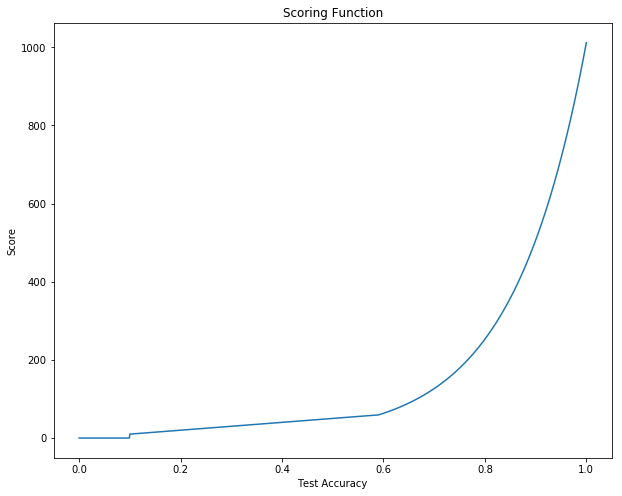

In [18]:
from dl4cv.data_utils import scoring_function

x = np.linspace(0, 1, num=1000)
plt.plot(x, scoring_function(x, lin_exp_boundary=0.59, doubling_rate=0.1))
plt.title('Scoring Function')
plt.xlabel('Test Accuracy')
plt.ylabel('Score')
plt.show()